# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [124]:
# Importar bibliotecas padrão (nenhuma neste caso)

# Importar bibliotecas de terceiros
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importar pacotes específicos de bibliotecas ou funções
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error

In [3]:
#Carregar base de dados
renda_raw = pd.read_csv('previsao_de_renda.csv')
renda_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

In [4]:
#Data Wrangling - Cleaning
# Remover dados faltantes
renda_raw = renda_raw.dropna()
renda_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12427 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             12427 non-null  int64  
 1   data_ref               12427 non-null  object 
 2   id_cliente             12427 non-null  int64  
 3   sexo                   12427 non-null  object 
 4   posse_de_veiculo       12427 non-null  bool   
 5   posse_de_imovel        12427 non-null  bool   
 6   qtd_filhos             12427 non-null  int64  
 7   tipo_renda             12427 non-null  object 
 8   educacao               12427 non-null  object 
 9   estado_civil           12427 non-null  object 
 10  tipo_residencia        12427 non-null  object 
 11  idade                  12427 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  12427 non-null  float64
 14  renda                  12427 non-null  float64
dtypes: bool

In [8]:
#Data Wrangling - Cleaning
# Remover colunas desnecessárias
renda = renda_raw.drop(['Unnamed: 0', 'data_ref', 'id_cliente'], axis=1)
renda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12427 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   12427 non-null  object 
 1   posse_de_veiculo       12427 non-null  bool   
 2   posse_de_imovel        12427 non-null  bool   
 3   qtd_filhos             12427 non-null  int64  
 4   tipo_renda             12427 non-null  object 
 5   educacao               12427 non-null  object 
 6   estado_civil           12427 non-null  object 
 7   tipo_residencia        12427 non-null  object 
 8   idade                  12427 non-null  int64  
 9   tempo_emprego          12427 non-null  float64
 10  qt_pessoas_residencia  12427 non-null  float64
 11  renda                  12427 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(5)
memory usage: 1.1+ MB


1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

In [66]:
# 01 - Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
# Separação dos dados em base de treino e base de teste
y = renda['renda']
X = pd.get_dummies(renda.drop(columns='renda'), drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [36]:
# 02 - Rode uma regularização ridge com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o R2 na base de testes. 
# Qual o melhor modelo?

# Listar os valores de alpha a serem utilizados
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

# Armazenar os R-Quadrados para cada valor de alpha
r2_rid_list = [] 

# Definir o modelo
modelo = smf.ols('renda ~ tempo_emprego', data = renda)

# Definir uma função para calcular os R-Quadrados 
def calcular_r2(y_test, y_pred):
    ss_res = np.sum((y_test - y_pred)**2)
    ss_tot = np.sum((y_test - np.mean(y_test))**2)
    return 1 - (ss_res / ss_tot)


# Iterar sobre os valores de alpha
for alpha in alphas:
    # Ajustar o modelo utilizando a regularização Ridge (L2 >> L1_wt=0)
    reg_rid = modelo.fit_regularized(method='elastic_net', 
                                     refit=True, 
                                     L1_wt=0, 
                                     alpha=alpha)
    # Fazer previsões
    y_pred = reg_rid.predict(X_test)
    
    # Calcular o R-Quadrado e adicionar a lista
    r2_rid = calcular_r2(y_test, y_pred)
    r2_rid_list.append(r2_rid)

# Retornar a lista de R-Quadrados
print(alphas)
print(r2_rid_list)

[0, 0.001, 0.005, 0.01, 0.05, 0.1]
[0.16131259213638294, 0.16131740034474795, 0.16133379955753802, 0.16134820064183863, 0.1612657458426634, 0.16083317587216095]


## RESPOSTA
Os modelos não apresentaram diferenças significativas em termos de desempenho. O valor mais alto para o R-Quadrado foi obtido com alpha = 0.01, com R-Quadrado de aproximadamente 0.1613, enquanto o valor mais baixo foi com alpha = 0.1, com R-Quadrado de 0.1608. A diferença máxima entre os dois melhores modelos (com alpha = 0.005 e alpha = 0.01) foi de apenas 0.0018%, o que pode indicar que a Regularização Ridge não trouxe melhorias substanciais sobre o modelo.

In [51]:
# 03 - Faça o mesmo que no passo 2, com uma regressão LASSO. Qual método chega a um melhor resultado?

# Armazenar os resultados do R² para Lasso
r2_las_list = []

# Iterar os valores de alpha
for alpha in alphas:
    # Ajustar o modelo utilizando a regularização Lasso (L1 >> L1_wt=1)
    reg_las = modelo.fit_regularized(method='elastic_net', 
                                       L1_wt=1, 
                                       refit=True,
                                       alpha=alpha)
    # Fazer previsões
    y_pred_las = reg_las.predict(X_test)
    
    # Calcular o R-Quadrado e adicionar a lista
    r2_las = calcular_r2(y_test, y_pred)
    r2_las_list.append(r2_las)

# Retornar tabela de R-Quadrados
r2 =pd.DataFrame({
    'Alpha': alphas,
    'Ridge': r2_rid_list,
    'Lasso': r2_las_list})

print(r2)

   Alpha     Ridge     Lasso
0  0.000  0.161313  0.160833
1  0.001  0.161317  0.160833
2  0.005  0.161334  0.160833
3  0.010  0.161348  0.160833
4  0.050  0.161266  0.160833
5  0.100  0.160833  0.160833


## Resposta: 
Após a regularização L2 os modelos não apresentaram nenhuma alteração significativa. Mesmo com a alteração do alpha, o R-Quadrado dos modelos permaneceu inalterado. Observa-se que o valor do R-Quadrado è o memso valor do menor R-Quadrado da regularização L1. Podemos concluir que a regularização Ridge apresentou maior efeito porém o fenonomeno observado não é significativo para justificar a escolha de um modelo sobre o outro. 

In [70]:
# 04 - Rode um modelo stepwise. Avalie o R-Quadrado na base de testes. Qual o melhor resultado?


# Garantir que todas as colunas de X e y sejam do tipo float
X = X.astype(float)
y = y.astype(float)

# Definir a função de seleção stepwise
def stepwise_selection(X_test, y_test,
                       initial_list=[],
                       threshold_in=0.05,
                       threshold_out=0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        # começamos pela lista de variaveis excluidas
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=np.float64)
        # para que toda variavel excluida vá sendo incluida e o p-value armazenado
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        # vai retirando as váriaveis menos significantes
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Executar a seleção stepwise
variaveis = stepwise_selection(X_test, y_test)

print('resulting features:')
print(variaveis)

Add  tempo_emprego                  with p-value 0.0
Add  sexo_M                         with p-value 0.0
Add  tipo_renda_Empresário          with p-value 1.75299e-07
Add  idade                          with p-value 1.9605e-07
Add  educacao_Superior completo     with p-value 3.07164e-06
Add  qt_pessoas_residencia          with p-value 0.00747762
Add  posse_de_imovel                with p-value 0.0138522
resulting features:
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior completo', 'qt_pessoas_residencia', 'posse_de_imovel']


In [95]:
mod_stw = 'renda ~ tempo_emprego + sexo + tipo_renda + idade + educacao + qt_pessoas_residencia + posse_de_imovel'
mod = smf.ols(mod_stw, data = renda)

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     304.8
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:42:11   Log-Likelihood:            -1.2879e+05
No. Observations:               12427   AIC:                         2.576e+05
Df Residuals:                   12413   BIC:                         2.577e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                       -3947.2300    854.037     -4.622      0.000   -5621.276   -2273.184
sexo[T.M]                        6087.0647    146.321     41.601      0.000    5800.253    6373.876
tipo_renda[T.Bolsista]          -1321.2957   2563.054     -0.516      0.606   -6345.279    3702.688
tipo_renda[T.Empresário]          816.2292    158.330      5.155      0.000     505.878    1126.580
tipo_renda[T.Pensionista]       -2825.5973   2561.409     -1.103      0.270   -7846.356    2195.161
tipo_renda[T.Servidor público]    135.3801    235.912      0.574      0.566    -327.044     597.804
educacao[T.Pós graduação]        1068.2331   1686.541      0.633      0.526   -2237.648    4374.114
educacao[T.Secundário]            595.8283    762.481      0.781      0.435    -898.752    2090.409
educacao[T.Superior completo]    1214.2466    765.604      1.586      0.113    -286.456    2714.950
educacao[T.Superior incompleto]   190.4879    824.180      0.231      0.817   -1425.032    1806.008
posse_de_imovel[T.True]           353.6617    145.637      2.428      0.015      68.190     639.133
tempo_emprego                     554.1097     11.014     50.308      0.000     532.520     575.700
idade                              45.4058      8.200      5.538      0.000      29.333      61.478
qt_pessoas_residencia             191.5689     76.195      2.514      0.012      42.215     340.923
==============================================================================
Omnibus:                    17579.310   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9929026.258
Skew:                           8.133   Prob(JB):                         0.00
Kurtosis:                     140.518   Cond. No.                     1.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
# 05 - Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?

## Resposta:

Todas as variáveis resultantes do Stepwise apresentam p-value menor que 0.05, isso sugere que o conjunto de variáveis selecionadas pelo stepwise é relevante para o modelo, pois contribuem significativamente para a explicação da variável dependente 'remda'. Isso sugere que o conjunto de variáveis selecionadas pelo stepwise é relevante para o modelo. Ao testar o modelo com as variáveis retornada no Stepwise observa-se que o modelo é capaz de explicar 25.6% da variabilidade da variável dependente. 

In [107]:
# 06 - Partindo dos modelos que você ajustou, tente melhorar o R-Quadrado na base de testes. 
# Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.

modelo = 'np.log(renda + 1) ~ tempo_emprego + sexo + tipo_renda + idade + educacao + qt_pessoas_residencia + posse_de_imovel'
mod = smf.ols(modelo, data = renda).fit()

mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(renda + 1)   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     527.6
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:48:11   Log-Likelihood:                -13579.
No. Observations:               12427   AIC:                         2.719e+04
Df Residuals:                   12413   BIC:                         2.729e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           7.0986      0.080     88.331      0.000       6.941       7.256
sexo[T.M]                           0.7997      0.014     58.083      0.000       0.773       0.827
tipo_renda[T.Bolsista]              0.1961      0.241      0.813      0.416      -0.277       0.669
tipo_renda[T.Empresário]            0.1536      0.015     10.307      0.000       0.124       0.183
tipo_renda[T.Pensionista]          -0.3165      0.241     -1.313      0.189      -0.789       0.156
tipo_renda[T.Servidor público]      0.0587      0.022      2.646      0.008       0.015       0.102
educacao[T.Pós graduação]           0.1143      0.159      0.721      0.471      -0.197       0.425
educacao[T.Secundário]             -0.0149      0.072     -0.207      0.836      -0.156       0.126
educacao[T.Superior completo]       0.0965      0.072      1.339      0.180      -0.045       0.238
educacao[T.Superior incompleto]    -0.0460      0.078     -0.593      0.553      -0.198       0.106
posse_de_imovel[T.True]             0.0833      0.014      6.077      0.000       0.056       0.110
tempo_emprego                       0.0615      0.001     59.384      0.000       0.060       0.064
idade                               0.0054      0.001      7.042      0.000       0.004       0.007
qt_pessoas_residencia               0.0221      0.007      3.084      0.002       0.008       0.036
==============================================================================
Omnibus:                        0.707   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.702   Jarque-Bera (JB):                0.688
Skew:                           0.017   Prob(JB):                        0.709
Kurtosis:                       3.012   Cond. No.                     1.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Resposta
A transformação logarítmica da variável dependente resultou em um aumento substancial no desempenho do modelo, conforme medido pelo R², passando de 25% para 35.6%. O R² Ajustado próximo ao R² não ajustado indica que o modelo é robusto, sem superajuste, e que a escolha das variáveis foi adequada.

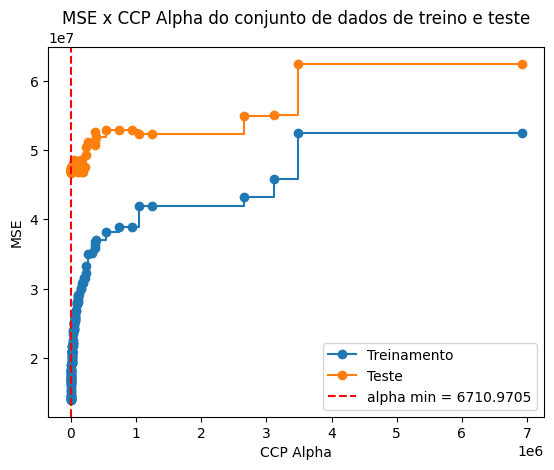

O valor de ccp_alpha que minimiza o MSE no conjunto de teste é: 6710.970531484243


In [126]:
# 07 - Ajuste uma árvore de regressão e veja se consegue um R-Quadrado melhor com ela.
# Gerar árvore
regr = DecisionTreeRegressor(max_depth=8)

# Treinar árvore
regr.fit(X_train, y_train)

# Fazer previsões sobre a base de treinamento
y_train_pred = regr.predict(X_train)

# Calcular os CCPS-Alphas
path = regr.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Treinar árvores com os caminhos obtidos
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Calcular MSE das árvores
train_scores = [mean_squared_error(y_train , clf.predict(X_train)) for clf in clfs]
test_scores = [mean_squared_error(y_test , clf.predict(X_test)) for clf in clfs]

# Plotar gráfico com os resultados
fig, ax = plt.subplots()

# Configurar gráfico
ax.set_xlabel("CCP Alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE x CCP Alpha do conjunto de dados de treino e teste")

# Plotar os MSEs para os dados de treinamento
ax.plot(ccp_alphas[:-1], train_scores[:-1], marker='o', label="Treinamento", drawstyle="steps-post")

# Plotar os MSEs para os dados de teste
ax.plot(ccp_alphas[:-1], test_scores[:-1], marker='o', label="Teste", drawstyle="steps-post")

# Adicionar uma linha vertical no ponto de mínimo do MSE do conjunto de teste
min_mse_index = np.argmin(test_scores[:-1])
best_ccp_alpha = ccp_alphas[min_mse_index]
ax.axvline(x=best_ccp_alpha, color='r', linestyle='--', label=f'alpha min = {best_ccp_alpha:.4f}')

# Adicionar legenda
ax.legend()

# Exibir o gráfico
plt.show()

print(f'O valor de ccp_alpha que minimiza o MSE no conjunto de teste é: {best_ccp_alpha}')

In [128]:
# Calcular os coeficientes de árvore com MSE mínimo
arv_fin = DecisionTreeRegressor(random_state=0, ccp_alpha=best_ccp_alpha)
arv_fin.fit(X_train, y_train)

print(f"Profundidade: {arv_fin.tree_.max_depth}")
print(f"R-quadrado na base de testes: {arv_fin.score(X_test, y_test):.2f}")
print(f"MSE na base de testes: {mean_squared_error(y_test, arv_fin.predict(X_test)):.2f}")

Profundidade: 24
R-quadrado na base de testes: 0.43
MSE na base de testes: 46728522.11


## Resposta:

Através da árvore de regressão com poda baseada no parâmetro ccp_alpha, o modelo conseguiu explicar 43% da variabilidade da variável dependente, conforme indicado pelo R-Quadrado de 0.43 no conjunto de teste. Apesar de um desempenho moderado, o MSE (Erro Quadrático Médio) na base de testes foi relativamente alto o que indica que o modelo ainda tem espaço para melhorias em termos de precisão.

Além disso, a profundidade da árvore foi de 24, o que sugere que o modelo é relativamente complexo. Modelos com alta profundidade podem ser propensos a overfitting.